# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Helpers to generate specfific vines and analyze there conditional independencies
from demos.pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 10  # dimension
rvine_structure = pv.RVineStructure.simulate(10)
pair_copulas = sample_random_pair_copulas(D, Independence_tree=3)
vine_model = pv.Vinecop.from_structure(
    structure=rvine_structure, pair_copulas=pair_copulas
)
df = compute_conditional_dependence_table(vine_model)
# df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:
df_true_structure = df[
    [
        "tree",
        "edge",
        "conditioned variables",
        "conditioned variable 1",
        "conditioned variable 2",
        "dependence",
        "var_row",
        "var_col",
    ]
]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

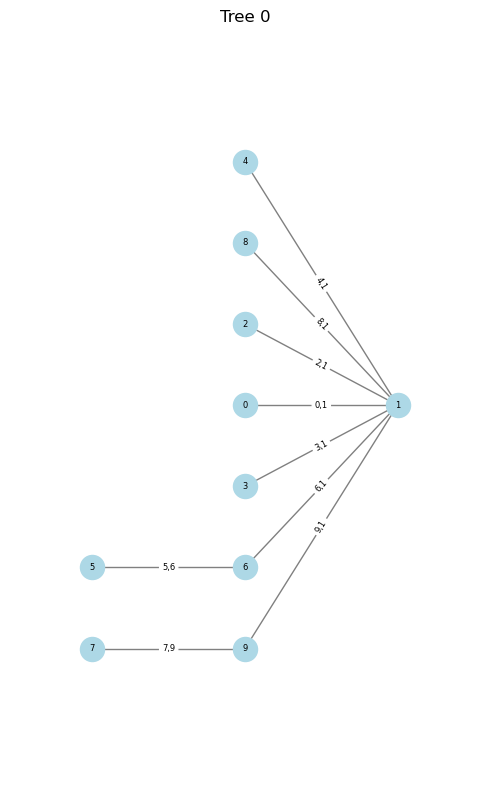

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = (
    torch.distributions.Normal(0, 1)
    .icdf(torch.tensor(simulated_data_uniform_train))
    .float()
)

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = (
    torch.distributions.Normal(0, 1)
    .icdf(torch.tensor(simulated_data_uniform_validate))
    .float()
)

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = (
    torch.distributions.Normal(0, 1)
    .icdf(torch.tensor(simulated_data_uniform_test))
    .float()
)

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0, 1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = (
    torch.distributions.Normal(0, 1).log_prob(simulated_data_validate).sum(1)
)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0, 1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = (
    torch.distributions.Normal(means, vars).log_prob(simulated_data_train).sum(1)
)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = (
    torch.distributions.Normal(means, vars).log_prob(simulated_data_validate).sum(1)
)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = (
    torch.distributions.Normal(means, vars).log_prob(simulated_data_test).sum(1)
)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model = GTM(
    number_variables=10,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
)

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
# model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
# model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model.hyperparameter_tune_penalties(
    train_dataloader=dataloader_train,
    validate_dataloader=dataloader_validate,
    penalty_decorrelation_ridge_param=None,
    penalty_decorrelation_ridge_first_difference="sample",
    penalty_decorrelation_ridge_second_difference="sample",
    penalty_transformation_ridge_second_difference=None,
    penalty_lasso_conditional_independence=None,
    adaptive_lasso_weights_matrix=False,
    optimizer="LBFGS",
    learning_rate=1,
    iterations=2000,
    patience=5,
    min_delta=1e-7,
    seperate_copula_training=False,
    max_batches_per_iter=False,
    pretrained_transformation_layer=True,
    n_trials=30,
    temp_folder=".",
    study_name=None,
)


penalty_splines_params = torch.FloatTensor(
    [
        0,  # study.best_params["penalty_decorrelation_ridge_param"],
        study.best_params["penalty_decorrelation_ridge_first_difference"],
        study.best_params["penalty_decorrelation_ridge_second_difference"],
        0,  # study.best_params["penalty_transformation_ridge_second_difference"]
    ]
)
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence = False

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-10 18:52:10,324] A new study created in RDB with name: no-name-e04e1c85-f9c9-4121-9162-0331689dbe7f
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:526: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
 14%|█▍        | 286/2000 [00:43<04:23,  6.51it/s]
[I 2025-06-10 18:52:55,262] T

hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model.pretrain_transformation_layer(
    dataloader_train,
    iterations=1000,
    max_batches_per_iter=False,
    penalty_splines_params=penalty_splines_params,
)

 14%|█▍        | 139/1000 [00:03<00:24, 34.94it/s]


In [16]:
# train the joint model
_ = model.train(
    train_dataloader=dataloader_train,
    validate_dataloader=dataloader_validate,
    iterations=1000,
    optimizer="LBFGS",
    penalty_splines_params=penalty_splines_params,
    adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix,
    penalty_lasso_conditional_independence=penalty_lasso_conditional_independence,
    max_batches_per_iter=False,
)

 24%|██▎       | 237/1000 [00:38<02:03,  6.19it/s]


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [17]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [18]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(
    loc=mean_mvn_model, covariance_matrix=cov_mvn_model
)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)

In [19]:
print(
    "KLD GTM      Train Data: ",
    np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(), 4),
)
print(
    "KLD Gaussian Train Data: ",
    np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(), 4),
)
print(
    "KLD Copula   Train Data: ",
    np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(), 4),
)

print(
    "KLD GTM      Test  Data: ",
    np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(), 4),
)
print(
    "KLD Gaussian Test  Data: ",
    np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(), 4),
)
print(
    "KLD Copula   Test  Data: ",
    np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(), 4),
)

KLD GTM      Train Data:  0.6158
KLD Gaussian Train Data:  3.3082
KLD Copula   Train Data:  0.0022
KLD GTM      Test  Data:  1.0126
KLD Gaussian Test  Data:  3.3215
KLD Copula   Test  Data:  0.0258


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [20]:
conditional_independence_table = model.compute_conditional_independence_table(
    y=None,
    evaluation_data_type="samples_from_model",
    num_processes=4,
    sample_size=5000,
    num_points_quad=15,
    copula_only=False,
    min_val=-6,
    max_val=6,
)

/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_model/gtm.py:838: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn("Transformation layer does not have an inverse. Inverse is approximated")


Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 6 with var_row_num 4 and var_col_num 0.


/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:526: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)
  t=knots.T,
/Users/matthiasherp/Desktop/phd_github_repositories/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:526: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/sr

Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 18 with var_row_num 6 and var_col_num 3.
Processing row 21 with var_row_num 7 and var_col_num 0.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 19 with var_row_num 6 and var_col_num 4.
Processing row 22 with var_row_num 7 and var_col_num 1.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 17 with var_row_num 6 and var_col_num 2

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [21]:
synthetic_samples = model.sample(2000)

/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/matthiasherp/anaconda3/envs/mctm_pytorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


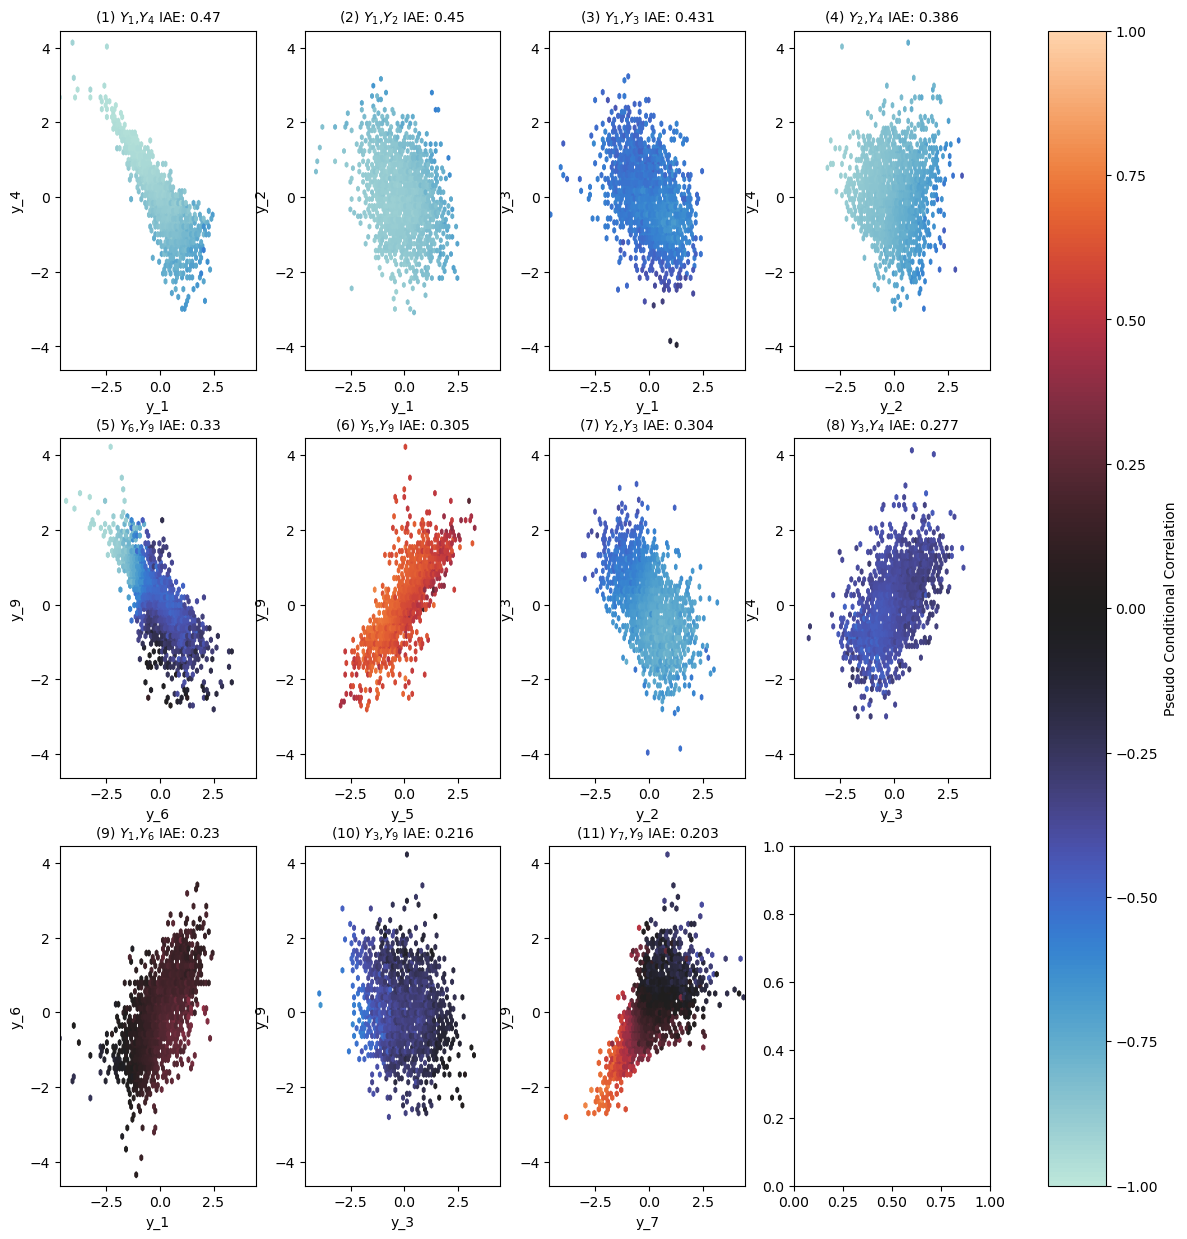

In [22]:
model.plot_conditional_dependence_structure(
    data=synthetic_samples,
    dependence_metric_threshholding="iae",
    minimum_dependence_threshold=0.2,
)

In [23]:
# model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [24]:
# model.plot_splines(layer_type="transformation")

In [25]:
# model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [26]:
# model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [27]:
# model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [28]:
merged_ci_tables = pd.merge(
    conditional_independence_table, df_true_structure_sub, on=["var_row", "var_col"]
)

take a look at the table and sort by some idicator such as iae.

In [29]:
# merged_ci_tables.sort_values("iae",ascending=False)

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [30]:
merged_ci_tables.corr("spearman")  # "pearson"

,index,var_row,var_col,precision_abs_mean,precision_square_mean,cond_correlation_abs_mean,cond_correlation_square_mean,kld,iae,dependence
index,1.000000,0.989071,0.589047,-0.055731,-0.042292,-0.072727,-0.056522,-0.007246,-0.013307,-0.194109
var_row,0.989071,1.000000,0.468889,-0.064872,-0.052884,-0.089316,-0.072732,-0.040295,-0.038630,-0.183765
var_col,0.589047,0.468889,1.000000,0.003530,0.018516,0.019249,0.027041,0.175502,0.131943,-0.192685
precision_abs_mean,-0.055731,-0.064872,0.003530,1.000000,0.996970,0.924638,0.935705,0.938735,0.962187,0.688203
precision_square_mean,-0.042292,-0.052884,0.018516,0.996970,1.000000,0.916469,0.931489,0.949144,0.969697,0.698791
cond_correlation_abs_mean,-0.072727,-0.089316,0.019249,0.924638,0.916469,1.000000,0.995125,0.848353,0.842556,0.596443
cond_correlation_square_mean,-0.056522,-0.072732,0.027041,0.935705,0.931489,0.995125,1.000000,0.871673,0.867194,0.628206
kld,-0.007246,-0.040295,0.175502,0.938735,0.949144,0.848353,0.871673,1.000000,0.976680,0.695261
iae,-0.013307,-0.038630,0.131943,0.962187,0.969697,0.842556,0.867194,0.976680,1.000000,0.709378
dependence,-0.194109,-0.183765,-0.192685,0.688203,0.698791,0.596443,0.628206,0.695261,0.709378,1.000000


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [31]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld"])
auc_corr = roc_auc_score(
    merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"]
)
auc_pmat = roc_auc_score(
    merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"]
)
print("AUC IAE                    :", auc_iae)
print("AUC KLD                    :", auc_kld)
print("AUC Conditional Correlation:", auc_corr)
print("AUC Precision Matrix       :", auc_pmat)

AUC IAE                    : 0.9222689075630253
AUC KLD                    : 0.9138655462184874
AUC Conditional Correlation: 0.8550420168067228
AUC Precision Matrix       : 0.9096638655462185


We further print the ROC Curves for different metrics.

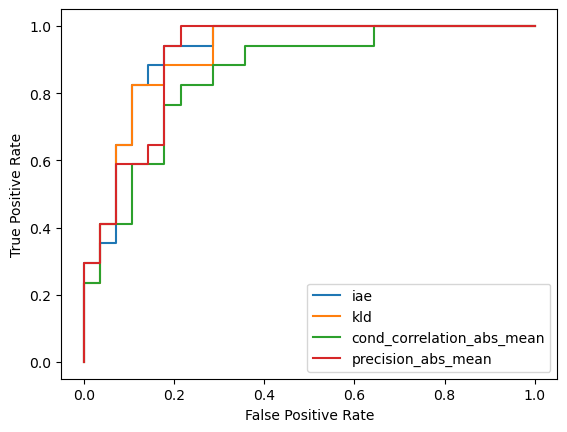

In [32]:
fpr, tpr, thresholds = roc_curve(
    merged_ci_tables["dependence"], merged_ci_tables["iae"]
)
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(
    merged_ci_tables["dependence"], merged_ci_tables["kld"]
)
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(
    merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"]
)
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(
    merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"]
)
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()